In [4]:
import os
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import json
import csv
import pandas as pd
import seaborn as sns

In [5]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [6]:
ROOT = '/mnt/data0/lucy/manosphere/'
SUBS = ROOT + 'data/submissions/'
SUB_META = ROOT + 'data/subreddits.txt'
LOGS = ROOT + 'logs/'

In [7]:
months = Counter()
for filename in tqdm(os.listdir(SUBS)): 
    if filename == 'bad_jsons': continue
    f = filename.replace('RS_', '').replace('RC_', '').replace('v2_', '').split('.')[0]
    i = 0
    for part in os.listdir(SUBS + filename):
        if not part.startswith('part-'): continue
        with open(SUBS + filename + '/' + part, 'r') as infile: 
            for line in infile: 
                i += 1
    months[f] = i

100%|██████████| 180/180 [00:47<00:00,  3.81it/s]


In [8]:
counts = []
month_names = []
for y in range(2005, 2020): 
    for m in range(1, 13): 
        if len(str(m)) == 1: 
            d = str(y) + '-0' + str(m)
        else:
            d = str(y) + '-' + str(m)
        counts.append(months[d])
        month_names.append(d)
x = [dt.datetime.strptime(d,'%Y-%m').date() for d in month_names][:-4]
counts = counts[:-4]

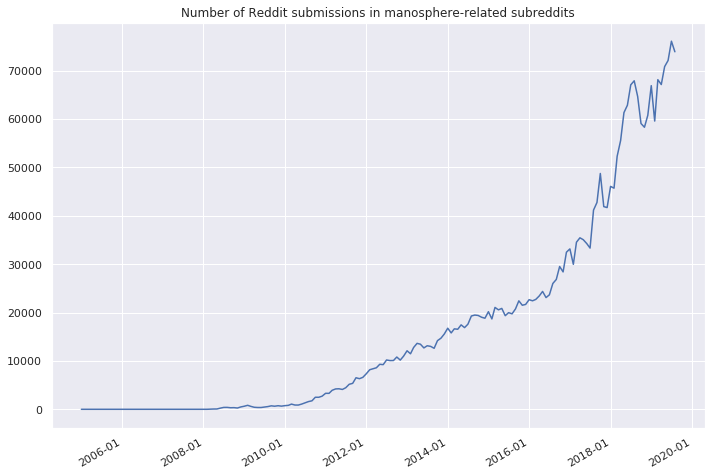

In [10]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(x,counts)
plt.gcf().autofmt_xdate()
plt.title("Number of Reddit submissions in manosphere-related subreddits")
plt.show()

In [11]:
sr_month = defaultdict(Counter)
for filename in tqdm(os.listdir(SUBS)): 
    if filename == 'bad_jsons': continue
    f = filename.replace('RS_', '').replace('RC_', '').replace('v2_', '').split('.')[0]
    subreddits = Counter()
    for part in os.listdir(SUBS + filename):
        if not part.startswith('part-'): continue
        with open(SUBS + filename + '/' + part, 'r') as infile: 
            for line in infile: 
                d = json.loads(line)
                subreddits[d['subreddit'].lower()] += 1
    for sr in subreddits: 
        sr_month[f][sr] = subreddits[sr]
with open(LOGS + 'submission_counts.json', 'w') as outfile:
    json.dump(sr_month, outfile)

100%|██████████| 180/180 [01:33<00:00,  1.93it/s]


In [12]:
with open(LOGS + 'submission_counts.json', 'r') as infile:
    sr_month = json.load(infile)

In [13]:
for month in sr_month: 
    if 'truefemcels' in sr_month[month]: 
        print(month)

2018-12
2019-04
2018-10
2018-09
2019-01
2019-03
2018-11
2019-02


In [14]:
# Get subreddit categories 
categories = defaultdict(str)
categories_rev = defaultdict(list)
with open(SUB_META, 'r') as infile: 
    reader = csv.DictReader(infile)
    for row in reader: 
        name = row['Subreddit'].strip().lower()
        if name.startswith('/r/'): name = name[3:]
        if name.startswith('r/'): name = name[2:]
        if name.endswith('/'): name = name[:-1]
        categories[name] = row['Category after majority agreement']
        categories_rev[row['Category after majority agreement']].append(name)

In [15]:
# Get subreddits missing from data 
all_srs = set(categories.keys()) 
found_srs = set()
banned = set(['malecels', '1ncels', 'incelspurgatory', 'incelbrotherhood', 'lonelynonviolentmen'])
for month in sr_month: 
    found_srs.update(sr_month[month].keys())
print(all_srs - found_srs - banned)
print(found_srs - all_srs)

{'philosophyofrape'}
set()


In [16]:
# The names of the categories we have
categories_rev.keys()

dict_keys(['TRP', 'MRA', 'PUA', 'Incels', 'Criticism', 'Health', 'MGTOW', 'Femcels', 'FDS'])

### Submissions

In [17]:
d = {'subreddit': [], 'category': [], 'month': [], 'count': []}
for month in sr_month: 
    for sr in sr_month[month]: 
        d['count'].append(sr_month[month][sr])
        d['category'].append(categories[sr])
        d['subreddit'].append(sr)
        d['month'].append(dt.datetime.strptime(month,'%Y-%m').date())
df = pd.DataFrame(data=d)

In [18]:
df

,subreddit,category,month,count
0,suicidewatch,Health,2009-07-01,137
1,mensrights,MRA,2009-07-01,285
2,depression,Health,2009-07-01,16
3,seduction,PUA,2009-07-01,22
4,socialanxiety,Health,2009-07-01,2
...,...,...,...,...
3767,geotrp,TRP,2015-06-01,2
3768,mrref,MRA,2015-06-01,2
3769,foreveraloneteens,Incels,2015-06-01,1
3770,mensrightslaw,MRA,2015-06-01,1


In [19]:
df_sum = df.groupby(['category', 'month']).sum().reset_index()
df_sum

,category,month,count
0,Criticism,2013-01-01,48
1,Criticism,2013-02-01,10
2,Criticism,2013-03-01,23
3,Criticism,2013-04-01,94
4,Criticism,2013-05-01,205
...,...,...,...
853,TRP,2019-12-01,3833
854,TRP,2020-01-01,3791
855,TRP,2020-02-01,3233
856,TRP,2020-03-01,3320


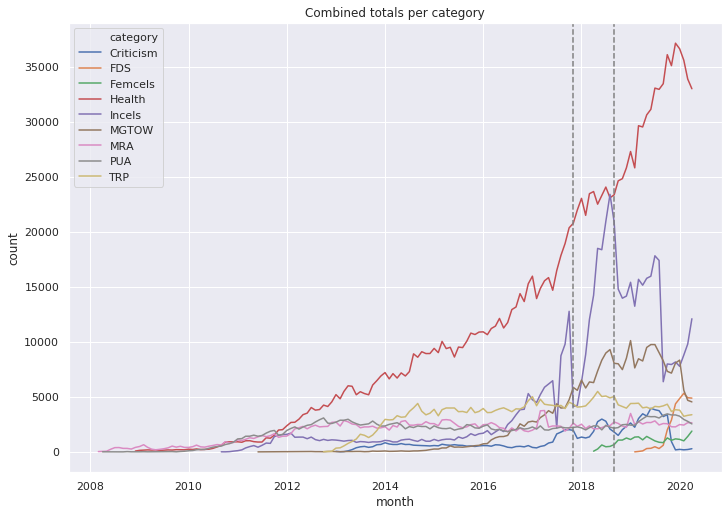

In [20]:
g = sns.lineplot(x="month", y="count", hue="category", data=df_sum)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

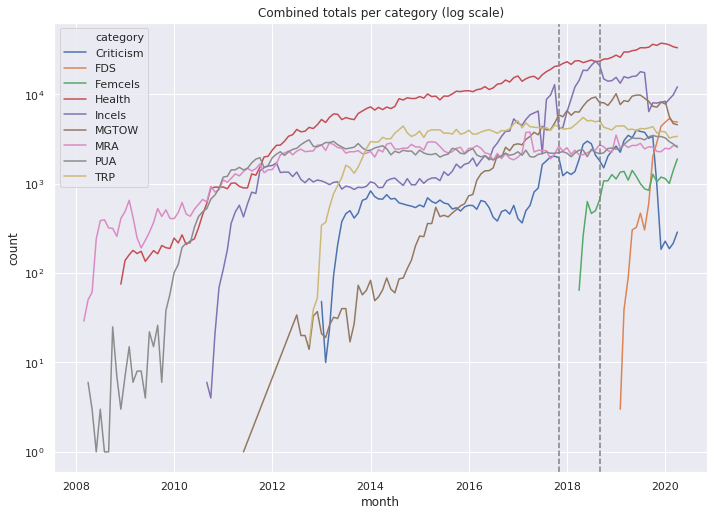

In [21]:
g = sns.lineplot(x="month", y="count", hue="category", data=df_sum)
g.set_yscale("log")
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category (log scale)")
plt.show()

In [22]:
def plot_over_time(cat, quarantine=False):
    cat_df = df[df['category'] == cat]
    sns.lineplot(x="month", y="count", hue="subreddit", data=cat_df)
    plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color='gray')
    if quarantine: 
        plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(cat)
    plt.show()

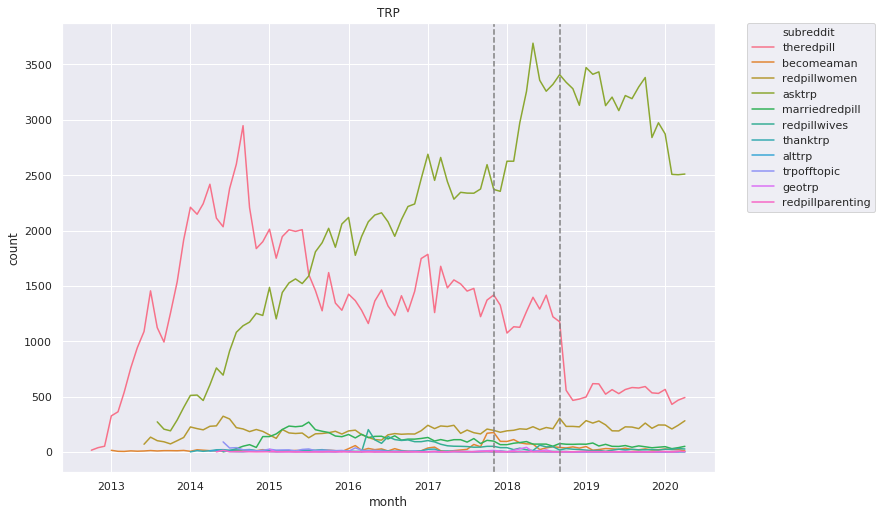

In [23]:
plot_over_time('TRP', quarantine=True)

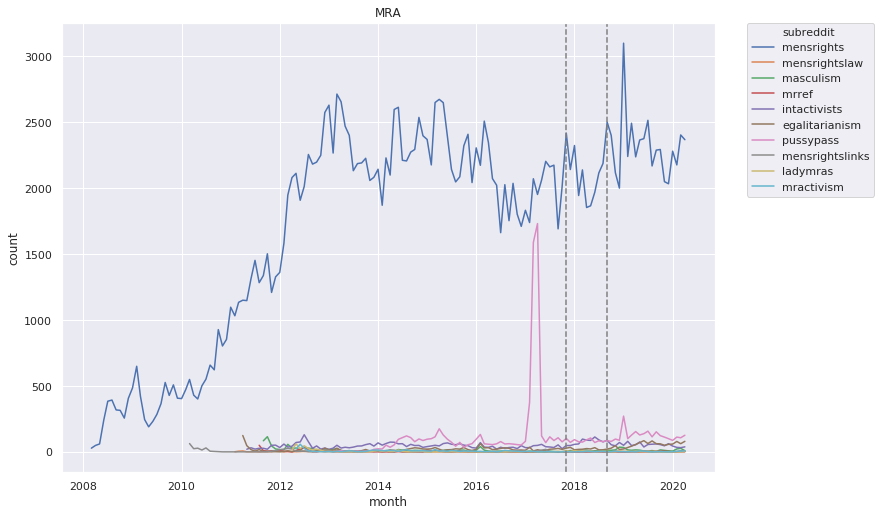

In [24]:
plot_over_time('MRA', quarantine=True)

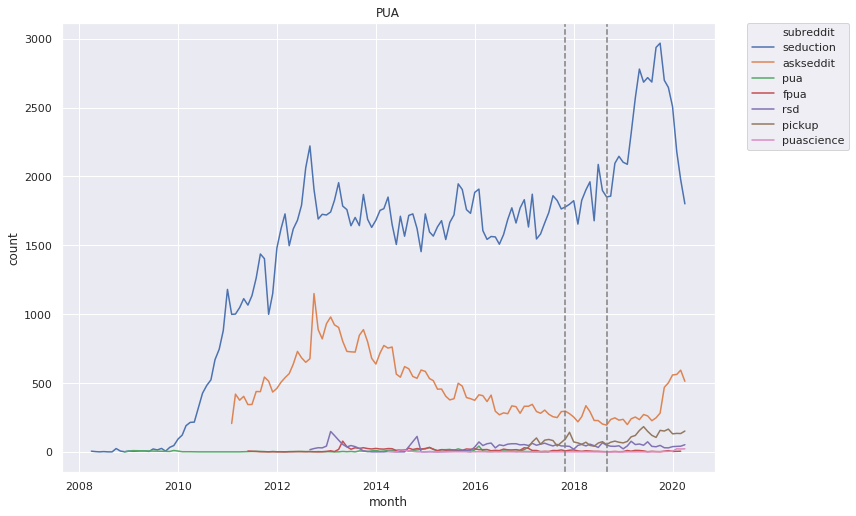

In [25]:
plot_over_time('PUA', quarantine=True)

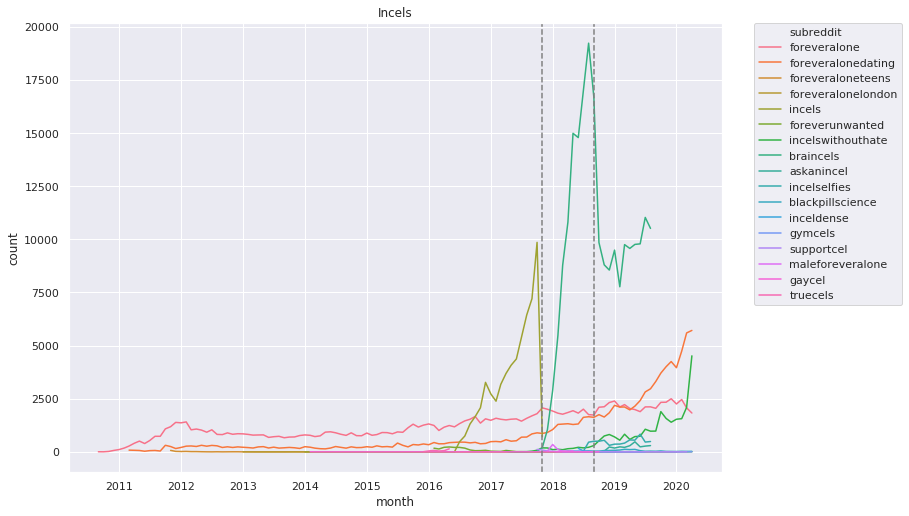

In [26]:
plot_over_time('Incels', quarantine=True)

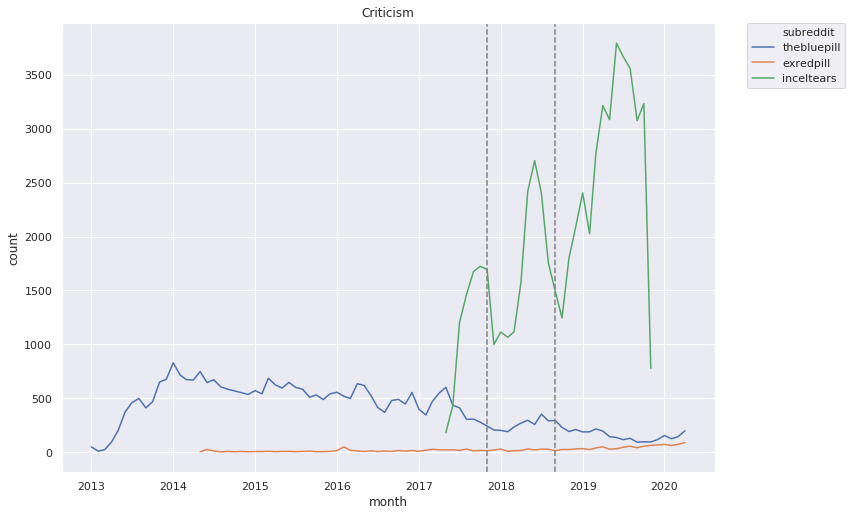

In [27]:
plot_over_time('Criticism', quarantine=True)

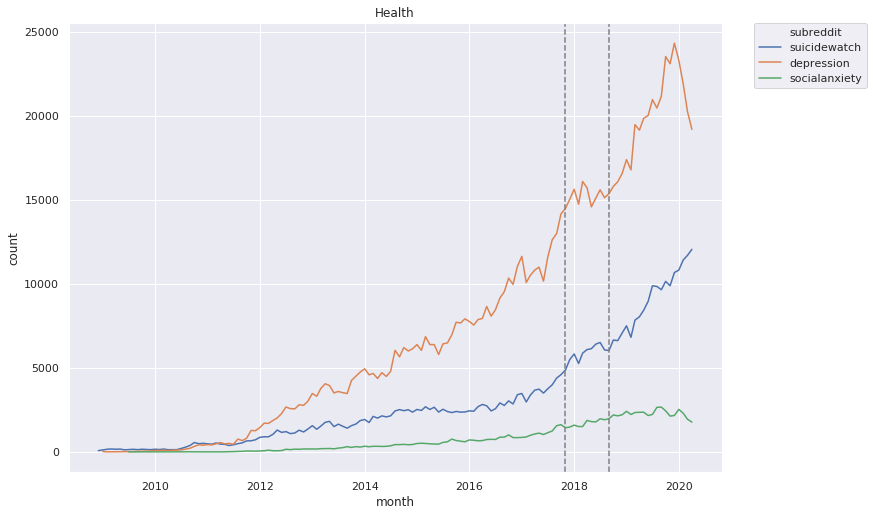

In [28]:
plot_over_time('Health', quarantine=True)

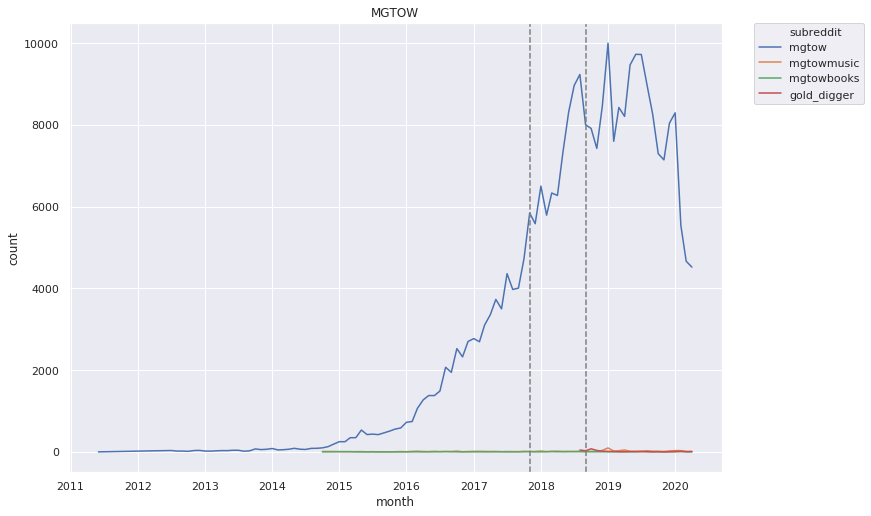

In [29]:
plot_over_time('MGTOW', quarantine=True)

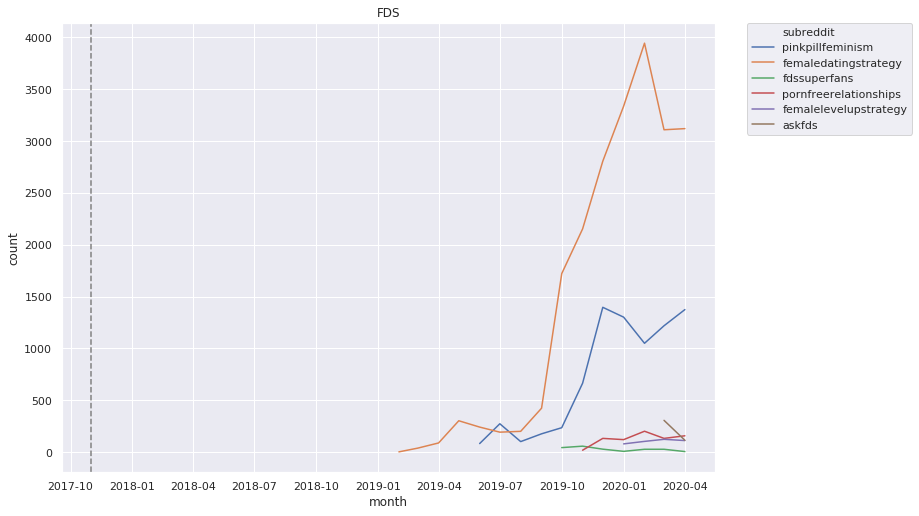

In [30]:
plot_over_time('FDS')

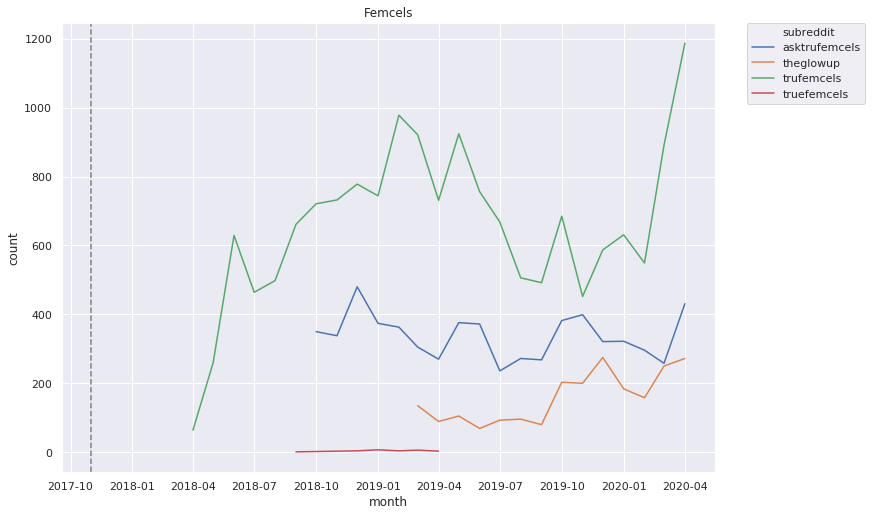

In [31]:
plot_over_time('Femcels')

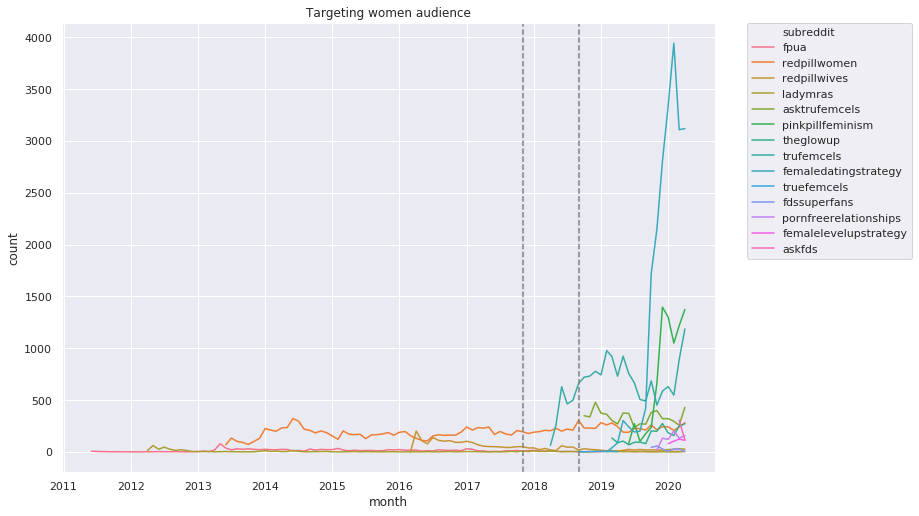

In [32]:
women = set(['redpillwives', 'redpillwomen', 'ladymras', 'truefemcels', 'fpua'])
women_df = df.loc[(df['subreddit'].isin(women)) | (df['category'] == 'FDS') | (df['category'] == 'Femcels')]
sns.lineplot(x="month", y="count", hue="subreddit", data=women_df)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color='gray')
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Targeting women audience")
plt.show()

### Comments

In [33]:
with open(LOGS + 'comment_counts.json', 'r') as infile:
    sr_coms = json.load(infile)

In [34]:
com_d = {'subreddit': [], 'category': [], 'month': [], 'comment_count': []}
for month in sr_coms: 
    for sr in sr_coms[month]: 
        com_d['comment_count'].append(sr_coms[month][sr])
        com_d['category'].append(categories[sr])
        com_d['subreddit'].append(sr)
        com_d['month'].append(dt.datetime.strptime(month,'%Y-%m').date())
com_df = pd.DataFrame(data=com_d)

In [35]:
com_df

,subreddit,category,month,comment_count
0,theredpill,TRP,2016-03-01,46554
1,seduction,PUA,2016-03-01,10641
2,askseddit,PUA,2016-03-01,2102
3,intactivists,MRA,2016-03-01,133
4,foreverunwanted,Incels,2016-03-01,3087
...,...,...,...,...
3308,masculism,MRA,2012-08-01,324
3309,mgtow,MGTOW,2012-08-01,24
3310,foreveraloneteens,Incels,2012-08-01,53
3311,pua,PUA,2012-08-01,10


In [37]:
df_sum_com = com_df.groupby(['category', 'month']).sum().reset_index()
df_sum_com

,category,month,comment_count
0,Criticism,2013-01-01,140
1,Criticism,2013-02-01,70
2,Criticism,2013-03-01,162
3,Criticism,2013-04-01,1659
4,Criticism,2013-05-01,3497
...,...,...,...
786,TRP,2019-05-01,58264
787,TRP,2019-06-01,59726
788,TRP,2019-07-01,61488
789,TRP,2019-08-01,59559


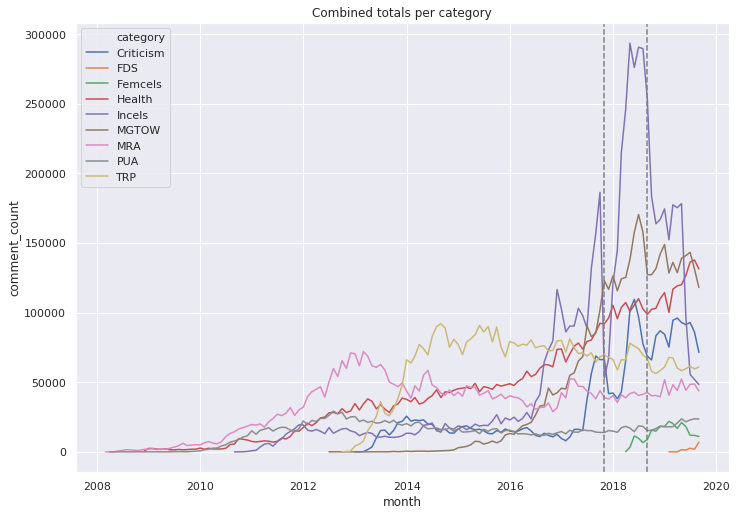

In [38]:
g = sns.lineplot(x="month", y="comment_count", hue="category", data=df_sum_com)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

In [39]:
all_df = pd.merge(df_sum, df_sum_com, on=['month', 'category'])
all_df['engagement'] = all_df['comment_count'] / all_df['count']
all_df

,category,month,count,comment_count,engagement
0,Criticism,2013-01-01,48,140,2.916667
1,Criticism,2013-02-01,10,70,7.000000
2,Criticism,2013-03-01,23,162,7.043478
3,Criticism,2013-04-01,94,1659,17.648936
4,Criticism,2013-05-01,205,3497,17.058537
...,...,...,...,...,...
786,TRP,2019-05-01,4064,58264,14.336614
787,TRP,2019-06-01,3904,59726,15.298668
788,TRP,2019-07-01,4133,61488,14.877329
789,TRP,2019-08-01,4091,59559,14.558543


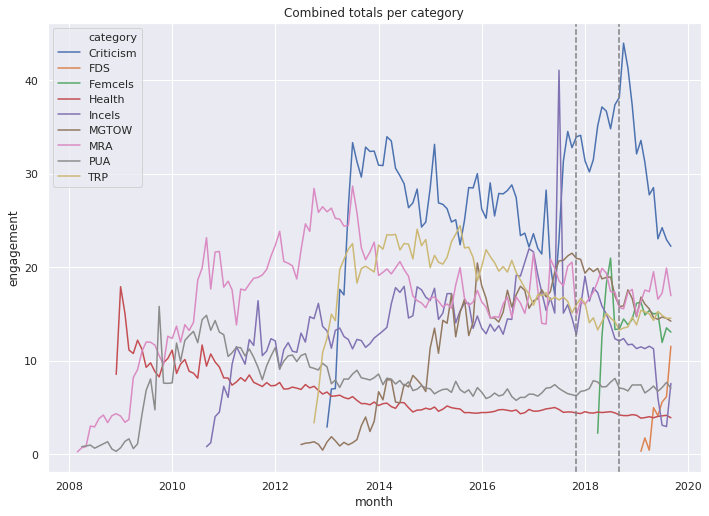

In [40]:
g = sns.lineplot(x="month", y="engagement", hue="category", data=all_df)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

### Forums

In [41]:
with open(LOGS + 'forum_count.json', 'r') as infile:
    forum_month = json.load(infile)

In [42]:
forum_d = {'forum': [], 'month': [], 'comment_count': []}
nones = Counter()
for month in forum_month: 
    for forum in forum_month[month]: 
        if month == 'None-None': 
            nones[forum] += forum_month[month][forum]
            continue
        forum_d['comment_count'].append(forum_month[month][forum])
        forum_d['forum'].append(forum)
        forum_d['month'].append(dt.datetime.strptime(month,'%Y-%m').date())
forum_df = pd.DataFrame(data=forum_d)
print(nones)

Counter({'rooshv': 2330})


In [43]:
forum_df

,forum,month,comment_count
0,red_pill_talk,2016-11-01,14410
1,avfm,2016-11-01,4022
2,rooshv,2016-11-01,12612
3,the_attraction,2016-11-01,190
4,pua_forum,2016-11-01,2549
...,...,...,...
799,pua_forum,2008-03-01,9164
800,the_attraction,2008-05-01,12924
801,pua_forum,2008-05-01,8001
802,the_attraction,1970-01-01,1


In [44]:
outliers = forum_df[forum_df['month'] < dt.datetime.strptime('2005-01','%Y-%m').date()]
outliers

,forum,month,comment_count
802,the_attraction,1970-01-01,1


In [45]:
forum_df = forum_df[forum_df['month'] >= dt.datetime.strptime('2005-01','%Y-%m').date()]

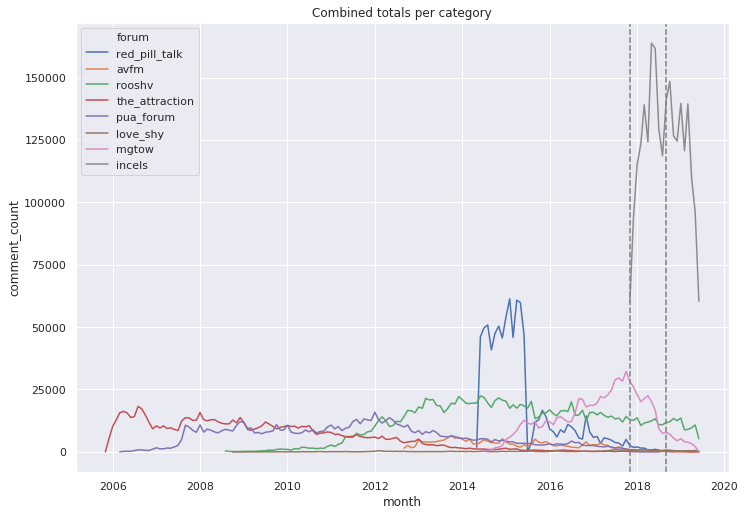

In [46]:
g = sns.lineplot(x="month", y="comment_count", hue="forum", data=forum_df)
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

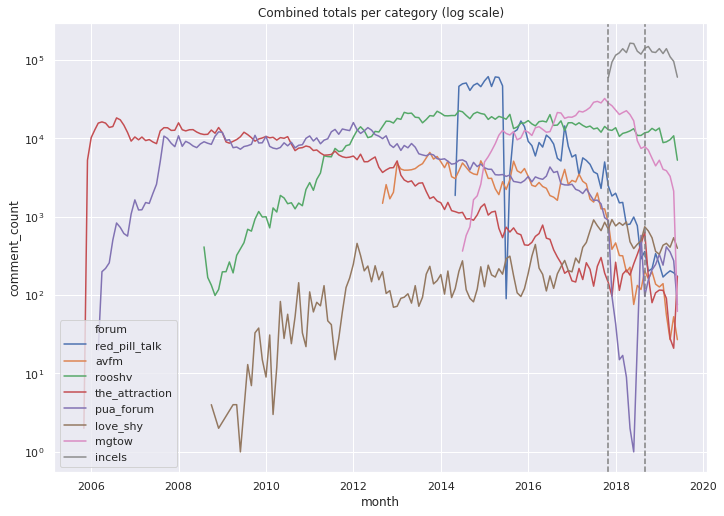

In [47]:
g = sns.lineplot(x="month", y="comment_count", hue="forum", data=forum_df)
g.set_yscale("log")
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category (log scale)")
plt.show()

### Big shifts

For some subreddits, look at major communities where there is a 90% decrease in posts, or a more than 500% increase. 

In [48]:
sr_df = pd.merge(df, com_df, on=['month', 'category', 'subreddit'])
sr_df['post_total'] = sr_df['count'] + sr_df['comment_count']
sr_df

,subreddit,category,month,count,comment_count,post_total
0,suicidewatch,Health,2009-07-01,137,1361,1498
1,mensrights,MRA,2009-07-01,285,3427,3712
2,depression,Health,2009-07-01,16,73,89
3,seduction,PUA,2009-07-01,22,151,173
4,socialanxiety,Health,2009-07-01,2,10,12
...,...,...,...,...,...,...
3193,ladymras,MRA,2015-06-01,1,1,2
3194,egalitarianism,MRA,2015-06-01,17,355,372
3195,mensrightslinks,MRA,2015-06-01,1,1,2
3196,geotrp,TRP,2015-06-01,2,14,16


In [49]:
sr_dates = sorted(set(sr_df['month'].tolist()))
srs = sorted(set(sr_df['subreddit'].tolist()))
sr_over_time = defaultdict(list) # keys are sr, values are a chronological list
for month in sr_dates: 
    for sr in srs: 
        month_f = str(month.year) + '-' + '{:02d}'.format(month.month) 
        t = 0
        if sr in sr_coms[month_f]: 
            t += sr_coms[month_f][sr]
        if sr in sr_month[month_f]:
            t += sr_month[month_f][sr]
        sr_over_time[sr].append(t)

In [50]:
for sr in sr_over_time: 
    prev_c = None
    for i, c in enumerate(sr_over_time[sr]): 
        if prev_c is not None: 
            if c <= 0.1*prev_c and not (c <= 100 and prev_c <= 100): 
                print(sr, sr_dates[i], "DECREASE:", prev_c, c)
            if c >= 5*prev_c and not prev_c == 0 and not (c <= 100 and prev_c <= 100): 
                print(sr, sr_dates[i], "INCREASE:", prev_c, c)
        prev_c = c

alttrp 2014-06-01 DECREASE: 105 2
askanincel 2018-12-01 INCREASE: 472 7213
becomeaman 2016-01-01 INCREASE: 34 200
blackpillscience 2018-04-01 INCREASE: 6 150
braincels 2017-11-01 INCREASE: 122 3758
braincels 2017-12-01 INCREASE: 3758 31743
braincels 2019-09-01 DECREASE: 10515 0
egalitarianism 2012-10-01 INCREASE: 18 140
femaledatingstrategy 2019-03-01 INCREASE: 4 108
femaledatingstrategy 2019-05-01 INCREASE: 129 1821
foreveralone 2010-11-01 INCREASE: 9 106
foreveralonedating 2011-10-01 INCREASE: 384 2545
fpua 2013-05-01 INCREASE: 98 1343
gymcels 2018-05-01 INCREASE: 12 299
incels 2016-07-01 INCREASE: 6 12474
incels 2017-11-01 DECREASE: 161843 10542
incels 2017-12-01 DECREASE: 10542 0
incelselfies 2018-08-01 INCREASE: 265 7382
incelselfies 2019-07-01 DECREASE: 8412 462
incelselfies 2019-09-01 DECREASE: 488 0
incelswithouthate 2017-08-01 INCREASE: 31 527
inceltears 2017-06-01 INCREASE: 314 2216
inceltears 2017-07-01 INCREASE: 2216 27203
ladymras 2013-03-01 INCREASE: 38 373
ladymras 2013-

In [51]:
def plot_over_time_single(sr):
    single_df = sr_df[sr_df['subreddit'] == sr]
    sns.lineplot(x="month", y="post_total", data=single_df)
    plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color='gray') 
    plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
    plt.title(sr)
    plt.show()

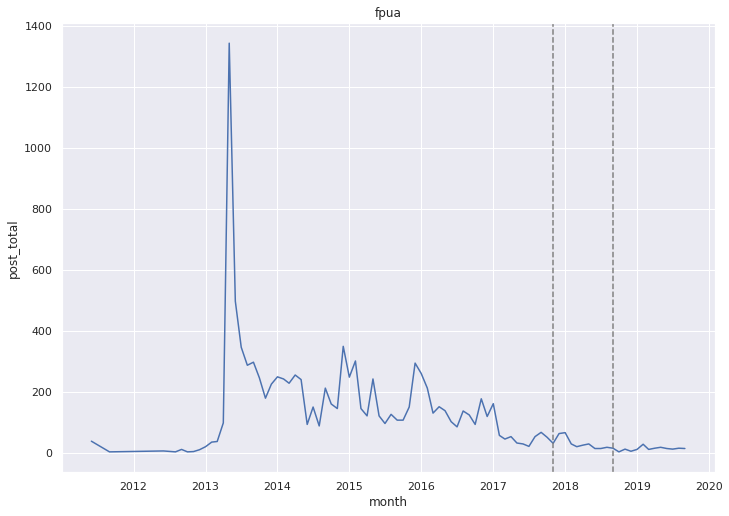

In [52]:
plot_over_time_single('fpua')

In [53]:
for i, val in enumerate(sr_over_time['fpua']):
    print(sr_dates[i], val)

2008-03-01 0
2008-04-01 0
2008-05-01 0
2008-06-01 0
2008-07-01 0
2008-08-01 0
2008-09-01 0
2008-10-01 0
2008-11-01 0
2008-12-01 0
2009-01-01 0
2009-02-01 0
2009-03-01 0
2009-04-01 0
2009-05-01 0
2009-06-01 0
2009-07-01 0
2009-08-01 0
2009-09-01 0
2009-10-01 0
2009-11-01 0
2009-12-01 0
2010-01-01 0
2010-02-01 0
2010-03-01 0
2010-04-01 0
2010-05-01 0
2010-06-01 0
2010-07-01 0
2010-08-01 0
2010-09-01 0
2010-10-01 0
2010-11-01 0
2010-12-01 0
2011-01-01 0
2011-02-01 0
2011-03-01 0
2011-04-01 0
2011-05-01 0
2011-06-01 38
2011-07-01 10
2011-08-01 3
2011-09-01 3
2011-10-01 0
2011-11-01 0
2011-12-01 0
2012-01-01 0
2012-02-01 0
2012-03-01 1
2012-04-01 0
2012-05-01 0
2012-06-01 6
2012-07-01 0
2012-08-01 3
2012-09-01 11
2012-10-01 3
2012-11-01 4
2012-12-01 10
2013-01-01 20
2013-02-01 35
2013-03-01 37
2013-04-01 98
2013-05-01 1343
2013-06-01 497
2013-07-01 346
2013-08-01 287
2013-09-01 297
2013-10-01 246
2013-11-01 179
2013-12-01 225
2014-01-01 249
2014-02-01 242
2014-03-01 228
2014-04-01 255
2014-

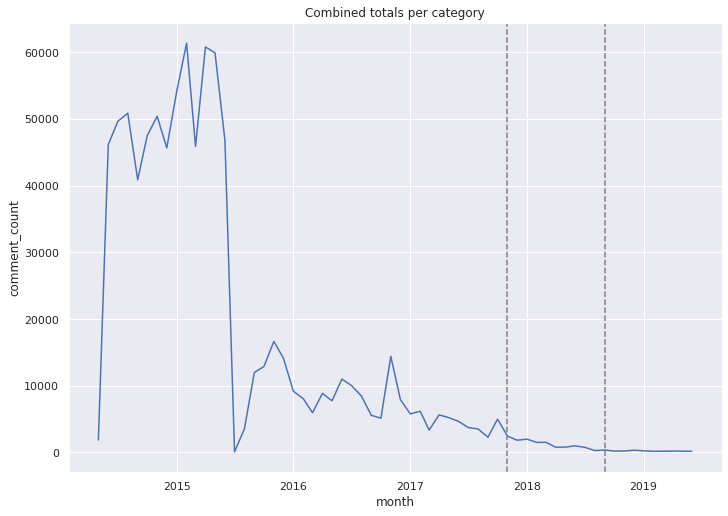

In [54]:
g = sns.lineplot(x="month", y="comment_count", data=forum_df[forum_df['forum'] == 'red_pill_talk'])
plt.axvline(x=dt.datetime.strptime('2017-11','%Y-%m').date(), linestyle='--', color="gray")
plt.axvline(x=dt.datetime.strptime('2018-09','%Y-%m').date(), linestyle='--', color='gray')
plt.title("Combined totals per category")
plt.show()

In [55]:
print(forum_df[forum_df['forum'] == 'red_pill_talk'].to_string())

             forum       month  comment_count
0    red_pill_talk  2016-11-01          14410
7    red_pill_talk  2016-07-01          10036
14   red_pill_talk  2017-02-01           6180
21   red_pill_talk  2016-01-01           9176
28   red_pill_talk  2017-09-01           2295
35   red_pill_talk  2016-05-01           7742
42   red_pill_talk  2017-11-01           2456
50   red_pill_talk  2016-09-01           5567
57   red_pill_talk  2016-12-01           7921
64   red_pill_talk  2017-01-01           5784
71   red_pill_talk  2017-05-01           5227
78   red_pill_talk  2016-03-01           5958
85   red_pill_talk  2016-06-01          10997
92   red_pill_talk  2018-06-01            991
100  red_pill_talk  2018-07-01            768
108  red_pill_talk  2015-09-01          11986
115  red_pill_talk  2015-10-01          12880
122  red_pill_talk  2015-11-01          16647
129  red_pill_talk  2016-10-01           5138
136  red_pill_talk  2017-06-01           4664
143  red_pill_talk  2017-12-01    